In [1]:
import numpy as np 
import pandas as pd
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')
#mpl.rcParams['xtick.labelsize'] = 8
#mpl.rcParams["image.cmap"] = 'gray'
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

%matplotlib inline

import datetime
date = datetime.datetime.now().strftime('%Y%m%d')

import os
path = '../../Avaatech'
os.chdir(path)

# Read and build spectral dataset

In [ ]:
spe_dir = glob.glob('SO264-15-2/Run 1 at  10kV/*.spe')

In [54]:
spe_all = []
depth_all = []
cps_all = []
file_name = []

for spe in spe_dir:
    start_depth = int(spe.split()[3].split('_')[-1])
    file_name.append(spe.split('/')[-1])
    with open(spe, 'r') as f:
        content = []
        lines = f.readlines()
        for line in lines[49:]:
            content = np.hstack((content, line.split()))

        spe_all.append(content.astype(int))
        # the depth read from the xrf depth is in mm, but the composite depth is in cm
        # also I check the depth is always starts from 0.0 and in 10.0 mm resulotion
        # so I use this trick to make it to cm  e.g. '1000.0\n'
        depth_all.append(int(lines[13][:-4]) + start_depth)
        cps_all.append(int(lines[28]))

In [24]:
# just to check if all depth can be store in integer
np.where((np.array(depth_all).round() == depth_all) == False)
# the answer is positive so I use a trick to store them in integer to save space

(array([], dtype=int64),)

In [55]:
data_df = pd.DataFrame(spe_all)
data_df['composite_depth_cm'] = depth_all
data_df['cps'] = cps_all
data_df['file_name'] = file_name

In [56]:
data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2041,2042,2043,2044,2045,2046,2047,composite_depth_cm,cps,file_name
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1082,179084,SO264-15-2_1048 340.0mm 10s 10kV 150uA No-F...
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1079,183695,SO264-15-2_1048 310.0mm 10s 10kV 150uA No-F...
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1404,132956,SO264-15-2_1348 560.0mm 10s 10kV 150uA No-F...
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,350,131934,SO264-15-2_0348 20.0mm 10s 10kV 150uA No-F...
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,41,129470,SO264-15-2_0000 410.0mm 10s 10kV 150uA No-F...


In [57]:
data_df.shape

(1442, 2051)

## Check duplicates

In [64]:
data_df.loc[data_df.composite_depth_cm.duplicated(keep = False), ['file_name', 'composite_depth_cm']].to_csv('duplicates.csv')

In [70]:
data_df.loc[data_df.composite_depth_cm.duplicated(), ['file_name', 'composite_depth_cm']]

,file_name,composite_depth_cm
474,SO264-15-2_0000 500.0mm 10s 10kV 150uA No-F...,50
735,SO264-15-2_048 240.0mm 10s 10kV 150uA No-Fi...,72
736,SO264-15-2_048 210.0mm 10s 10kV 150uA No-Fi...,69
739,SO264-15-2_0048 310.0mm 10s 10kV 150uA No-F...,79
740,SO264-15-2_0048 340.0mm 10s 10kV 150uA No-F...,82
...,...,...
1409,SO264-15-2_0048 470.0mm 10s 10kV 150uA No-F...,95
1410,SO264-15-2_0048 420.0mm 10s 10kV 150uA No-F...,90
1426,SO264-15-2_048 880.0mm 10s 10kV 150uA No-Fi...,136
1434,SO264-15-2_0048 980.0mm 10s 10kV 150uA No-F...,146


In [63]:
data_df.loc[data_df.composite_depth_cm == 50, ['file_name', 'composite_depth_cm']]

,file_name,composite_depth_cm
236,SO264-15-2_0048 20.0mm 10s 10kV 150uA No-F...,50
474,SO264-15-2_0000 500.0mm 10s 10kV 150uA No-F...,50
1074,SO264-15-2_048 20.0mm 10s 10kV 150uA No-Fi...,50


It does have duplicates...I reckon it's caused by a mess duplicate scanning. I only preserve the first one (0048) because its naming is matched to others.

In [69]:
clean_df = data_df[~data_df.composite_depth_cm.duplicated()]
clean_df.shape

(1340, 2051)

## Export data

In [77]:
clean_df.to_csv('clean_spe_SO264-15-2.csv', index = False)

# Merge with the bulk measurement by depth

In [58]:
clean_df = pd.read_csv('clean_spe.csv')
print(clean_df.shape)
print(clean_df.head())
bulk_df = pd.read_excel('SO264-15-2_bulk.xlsx', sheet_name = 'Sheet2')
bulk_df.columns = ['mid_depth_cm', 'toc_percent', 'tc_percent', 'caco3_percent']
print(bulk_df.shape)
print(bulk_df.head())

(1340, 2051)
   0  1  2  3  4  5  6  7  8  9  ...  2041  2042  2043  2044  2045  2046  \
0  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
1  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
2  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
3  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
4  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   

   2047  composite_depth_cm     cps  \
0     0                1082  179084   
1     0                1079  183695   
2     0                1404  132956   
3     0                 350  131934   
4     0                  41  129470   

                                           file_name  
0  SO264-15-2_1048  340.0mm  10s  10kV 150uA No-F...  
1  SO264-15-2_1048  310.0mm  10s  10kV 150uA No-F...  
2  SO264-15-2_1348  560.0mm  10s  10kV 150uA No-F...  
3  SO264-15-2_0348   20.0mm  10s  10kV 150uA No-F...  
4  SO264-15-2_0000  

In [59]:
# just check
bulk_df[bulk_df.mid_depth_cm.duplicated()]

,mid_depth_cm,toc_percent,tc_percent,caco3_percent


In [60]:
mask_c = (clean_df.columns != 'file_name') & (clean_df.columns != 'composite_depth_cm')
merge_df = pd.DataFrame()

for row in bulk_df.iterrows():
    mid = row[1][0]
    mask_i = (clean_df.composite_depth_cm >= int(mid)) & (clean_df.composite_depth_cm <= int(mid)+1)
    merge_df = pd.concat(
        [merge_df, clean_df.loc[mask_i, mask_c].apply(np.mean, axis = 0).append(row[1])],
        axis = 1
    )
    
merge_df = merge_df.T.reset_index(drop = True)

In [55]:
merge_df.shape

(40, 2053)

In [61]:
merge_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2043,2044,2045,2046,2047,cps,mid_depth_cm,toc_percent,tc_percent,caco3_percent
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,153268.5,10.5,0.181999,8.000254,65.149516
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,122791.5,20.5,0.298746,6.007120,47.567882
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,133795.0,46.5,0.288175,6.747430,53.824967
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,152620.5,68.5,0.299631,6.199101,49.160281
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,161830.5,88.5,0.240458,7.642422,61.680569


In [74]:
merge_df.apply(np.isnan, axis = 0)

,0,1,2,3,4,5,6,7,8,9,...,2043,2044,2045,2046,2047,cps,mid_depth_cm,toc_percent,tc_percent,caco3_percent
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [75]:
bulk_df.apply(np.isnan, axis = 0)

,mid_depth_cm,toc_percent,tc_percent,caco3_percent
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False
5,False,False,False,False
6,False,False,False,False
7,False,False,False,False
8,False,False,False,False
9,False,False,False,False


In [76]:
merge_df.iloc[21:23, :]

,0,1,2,3,4,5,6,7,8,9,...,2043,2044,2045,2046,2047,cps,mid_depth_cm,toc_percent,tc_percent,caco3_percent
21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,780.5,0.123676,8.799115,72.292438
22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,800.5,0.098591,10.975090,90.633864


It means avvatech doesn't have XRF data in these two depths...

In [85]:
clean_df[(clean_df.composite_depth_cm >= 750) & (clean_df.composite_depth_cm <= 840)]

,0,1,2,3,4,5,6,7,8,9,...,2041,2042,2043,2044,2045,2046,2047,composite_depth_cm,cps,file_name


In [86]:
merge_df = merge_df.dropna()
merge_df.shape

(38, 2053)

## Export data

In [87]:
merge_df.to_csv('merged.csv', index = False)

# Run regressions
1. ridged linear regression
2. kernel SVM(PCA or NMF)

In [2]:
merge_df = pd.read_csv('merged.csv')
X = merge_df.iloc[:, :-4].values

## CaCO3

In [3]:
y = merge_df.caco3_percent.values

In [90]:
%%time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pca = make_pipeline(StandardScaler(), PCA())
pca.fit(X)

CPU times: user 57 ms, sys: 38.1 ms, total: 95 ms
Wall time: 195 ms


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False))],
         verbose=False)

In [97]:
len(pca.named_steps['pca'].explained_variance_ratio_)

38

<BarContainer object of 38 artists>

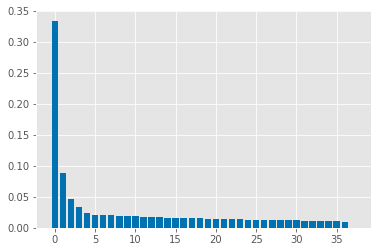

In [98]:
plt.bar(range(38), pca.named_steps['pca'].explained_variance_ratio_)

In [100]:
np.sum(pca.named_steps['pca'].explained_variance_ratio_)

1.0000000000000002

In [5]:
%%time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
ridge = make_pipeline(StandardScaler(), PCA(whiten = True), Ridge())
ridge.fit(X_train, y_train)

print('Training set score: {:.2f}'.format(ridge.score(X_train, y_train)))
print('Test set score: {:.2f}'.format(ridge.score(X_test, y_test)))

Training set score: 1.00
Test set score: 0.93
CPU times: user 26.1 ms, sys: 5.92 ms, total: 32 ms
Wall time: 67.3 ms


In [105]:
%%time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR

svr = make_pipeline(StandardScaler(), PCA(whiten = True), SVR())
svr.fit(X, y)

print('Training set score: {:.2f}'.format(svr.score(X_train, y_train)))
print('Test set score: {:.2f}'.format(svr.score(X_test, y_test)))

Training set score: 0.07
Test set score: 0.06
CPU times: user 24.4 ms, sys: 4.14 ms, total: 28.5 ms
Wall time: 19.3 ms


In [7]:
%%time
from sklearn.decomposition import NMF
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR


svr = make_pipeline(NMF(n_components = 5, random_state = 24), SVR())
svr.fit(X, y)

print('Training set score: {:.2f}'.format(svr.score(X_train, y_train)))
print('Test set score: {:.2f}'.format(svr.score(X_test, y_test)))

Training set score: 0.49
Test set score: 0.51
CPU times: user 183 ms, sys: 7.22 ms, total: 190 ms
Wall time: 155 ms


## GridsearchCV

In [116]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

ridge = make_pipeline(StandardScaler(), PCA(whiten = True), Ridge())
params = {'ridge__alpha': np.logspace(-8, 1, 10)}
grid = GridSearchCV(ridge, param_grid = params, cv = 5, n_jobs = -1)

grid.fit(X, y)

print('The best cv score: {:.3f}'.format(grid.best_score_))
print('The best parameter: {}'.format(grid.best_params_))
print(grid.best_estimator_)

The best cv score: 0.875
The best parameter: {'ridge__alpha': 1e-08}
Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=True)),
                ('ridge',
                 Ridge(alpha=1e-08, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)
CPU times: user 191 ms, sys: 20.7 ms, total: 211 ms
Wall time: 454 ms


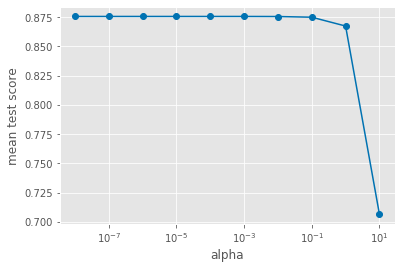

In [119]:
plt.plot(params['ridge__alpha'], grid.cv_results_['mean_test_score'], marker = 'o')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('mean test score')
fig.savefig('caco3_pca+ridge_grid_scores.png')

In [96]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(StandardScaler(), PCA(n_components = 5, whiten = True), SVR())
params = {
    'svr__C': np.logspace(-3, 5, 9),
    'svr__gamma': np.logspace(-5, 3, 9)
}
grid = GridSearchCV(pipe, param_grid = params, cv = 5, n_jobs = -1)

grid.fit(X, y)

print('The best cv score: {:.2f}'.format(grid.best_score_))
print('The best parameter: {}'.format(grid.best_params_))
print(grid.best_estimator_)

The best cv score: 0.89
The best parameter: {'svr__C': 100000.0, 'svr__gamma': 0.001}
Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=True)),
                ('svr',
                 SVR(C=100000.0, cache_size=200, coef0=0.0, degree=3,
                     epsilon=0.1, gamma=0.001, kernel='rbf', max_iter=-1,
                     shrinking=True, tol=0.001, verbose=False))],
         verbose=False)
CPU times: user 979 ms, sys: 44 ms, total: 1.02 s
Wall time: 2.86 s


In [97]:
result_df = pd.DataFrame(grid.cv_results_)
#result_df = result_df[result_df.mean_test_score > -1].reset_index(drop = True)

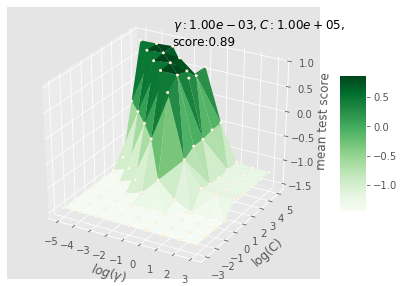

In [98]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize = (7,5))
ax = fig.gca(projection='3d')
xx = result_df.param_svr__gamma.astype(float)
yy = result_df.param_svr__C.astype(float)
zz = result_df.mean_test_score.astype(float)
max_index = np.argmax(zz)

surf = ax.plot_trisurf(np.log10(xx), np.log10(yy), zz, cmap=cm.Greens, linewidth=0.1)
ax.scatter3D(np.log10(xx), np.log10(yy), zz, c = 'orange', s = 5)
# mark the best score
ax.scatter3D(np.log10(xx), np.log10(yy), zz, c = 'w', s = 5, alpha = 1)
text = '$\gamma :{:.2e}, C:{:.2e}$,\nscore:{:.2f}'.format(xx[max_index], yy[max_index], zz[max_index])
ax.text(np.log10(xx[max_index]), np.log10(yy[max_index]), 
        zz[max_index],text,
        fontsize=12)

ax.set_xlabel('$log(\gamma)$')
ax.set_ylabel('log(C)')
ax.set_zlabel('mean test score')
fig.colorbar(surf, shrink=0.5, aspect=5)
fig.savefig('caco3_pca+svr_grid_scores_3D.png')

In [80]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import NMF
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(NMF(n_components = 5, random_state = 24), SVR())
params = {
    'svr__C': np.logspace(0, 7, 8),
    'svr__gamma': np.logspace(-8, 1, 10)
}
grid = GridSearchCV(pipe, param_grid = params, cv = 5, n_jobs = -1)

grid.fit(X, y)

print('The best cv score: {:.2f}'.format(grid.best_score_))
print('The best parameter: {}'.format(grid.best_params_))
print(grid.best_estimator_)

The best cv score: 0.92
The best parameter: {'svr__C': 1000000.0, 'svr__gamma': 1e-07}
Pipeline(memory=None,
         steps=[('nmf',
                 NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0,
                     max_iter=200, n_components=5, random_state=24,
                     shuffle=False, solver='cd', tol=0.0001, verbose=0)),
                ('svr',
                 SVR(C=1000000.0, cache_size=200, coef0=0.0, degree=3,
                     epsilon=0.1, gamma=1e-07, kernel='rbf', max_iter=-1,
                     shrinking=True, tol=0.001, verbose=False))],
         verbose=False)
CPU times: user 1.39 s, sys: 88 ms, total: 1.47 s
Wall time: 17.4 s


In [81]:
result_df = pd.DataFrame(grid.cv_results_)
result_df = result_df[result_df.mean_test_score > -1].reset_index(drop = True)

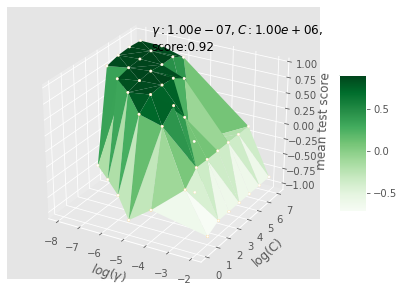

In [82]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize = (7,5))
ax = fig.gca(projection='3d')
xx = result_df.param_svr__gamma.astype(float)
yy = result_df.param_svr__C.astype(float)
zz = result_df.mean_test_score.astype(float)
max_index = np.argmax(zz)

surf = ax.plot_trisurf(np.log10(xx), np.log10(yy), zz, cmap=cm.Greens, linewidth=0.1)
ax.scatter3D(np.log10(xx), np.log10(yy), zz, c = 'orange', s = 5)
# mark the best score
ax.scatter3D(np.log10(xx), np.log10(yy), zz, c = 'w', s = 5, alpha = 1)
text = '$\gamma :{:.2e}, C:{:.2e}$,\nscore:{:.2f}'.format(xx[max_index], yy[max_index], zz[max_index])
ax.text(np.log10(xx[max_index]), np.log10(yy[max_index]), 
        zz[max_index],text,
        fontsize=12)

ax.set_xlabel('$log(\gamma)$')
ax.set_ylabel('log(C)')
ax.set_zlabel('mean test score')
fig.colorbar(surf, shrink=0.5, aspect=5)
fig.savefig('caco3_nmr+svr_grid_scores_3D.png')

### Short summary
It seems the ridge can provide reasonable prediction already. The combination of NMF and SVR produce the best prediction in cross-validation. The n_components is decided by the explaied variance of PCA. 

## TOC

In [149]:
y = merge_df.toc_percent.values

## GridsearchCV

In [134]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

ridge = make_pipeline(StandardScaler(), PCA(whiten = True), Ridge())
params = {'ridge__alpha': np.logspace(-3, 3, 7)}
grid = GridSearchCV(ridge, param_grid = params, cv = 5, n_jobs = -1)

grid.fit(X, y)

print('The best cv score: {:.2f}'.format(grid.best_score_))
print('The best parameter: {}'.format(grid.best_params_))
print(grid.best_estimator_)

The best cv score: 0.02
The best parameter: {'ridge__alpha': 0.001}
Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=True)),
                ('ridge',
                 Ridge(alpha=0.001, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)
CPU times: user 196 ms, sys: 67.6 ms, total: 263 ms
Wall time: 1.84 s


### Transform y by TransformedTargetRegressor

In [151]:
%%time
from sklearn.compose import TransformedTargetRegressor
transformer = StandardScaler()
regressor = make_pipeline(StandardScaler(), PCA(whiten = True), Ridge())
regr = TransformedTargetRegressor(regressor=regressor,
                                 transformer=transformer)
params = {'regressor__ridge__alpha': np.logspace(-3, 3, 7)}
grid = GridSearchCV(regr, param_grid = params, cv = 5, n_jobs = -1)

grid.fit(X, y)

print('The best cv score: {:.2f}'.format(grid.best_score_))
print('The best parameter: {}'.format(grid.best_params_))
print(grid.best_estimator_)

The best cv score: 0.02
The best parameter: {'regressor__ridge__alpha': 0.001}
TransformedTargetRegressor(check_inverse=True, func=None, inverse_func=None,
                           regressor=Pipeline(memory=None,
                                              steps=[('standardscaler',
                                                      StandardScaler(copy=True,
                                                                     with_mean=True,
                                                                     with_std=True)),
                                                     ('pca',
                                                      PCA(copy=True,
                                                          iterated_power='auto',
                                                          n_components=None,
                                                          random_state=None,
                                                          svd_solver='auto',
                    

In [152]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor

pipe = make_pipeline(StandardScaler(), PCA(n_components = 5, whiten = True), SVR())
regr = TransformedTargetRegressor(regressor = pipe,
                                 transformer = StandardScaler())
params = {
    'regressor__svr__C': np.logspace(-3, 3, 7),
    'regressor__svr__gamma': np.logspace(-3, 3, 7)
}

grid = GridSearchCV(regr, param_grid = params, cv = 5, n_jobs = -1)

grid.fit(X, y)

print('The best cv score: {:.2f}'.format(grid.best_score_))
print('The best parameter: {}'.format(grid.best_params_))
print(grid.best_estimator_)

The best cv score: 0.08
The best parameter: {'regressor__svr__C': 100.0, 'regressor__svr__gamma': 0.001}
TransformedTargetRegressor(check_inverse=True, func=None, inverse_func=None,
                           regressor=Pipeline(memory=None,
                                              steps=[('standardscaler',
                                                      StandardScaler(copy=True,
                                                                     with_mean=True,
                                                                     with_std=True)),
                                                     ('pca',
                                                      PCA(copy=True,
                                                          iterated_power='auto',
                                                          n_components=5,
                                                          random_state=None,
                                                          svd_solver='auto

In [155]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import NMF
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor

pipe = make_pipeline(NMF(n_components = 5, random_state = 24), SVR())
regr = TransformedTargetRegressor(regressor = pipe, transformer = StandardScaler())
params = {
    'regressor__svr__C': np.logspace(0, 7, 8),
    'regressor__svr__gamma': np.logspace(-8, 1, 10)
}
grid = GridSearchCV(regr, param_grid = params, cv = 5, n_jobs = -1)

grid.fit(X, y)

print('The best cv score: {:.2f}'.format(grid.best_score_))
print('The best parameter: {}'.format(grid.best_params_))
print(grid.best_estimator_)

The best cv score: 0.05
The best parameter: {'regressor__svr__C': 1000.0, 'regressor__svr__gamma': 1e-08}
TransformedTargetRegressor(check_inverse=True, func=None, inverse_func=None,
                           regressor=Pipeline(memory=None,
                                              steps=[('nmf',
                                                      NMF(alpha=0.0,
                                                          beta_loss='frobenius',
                                                          init=None,
                                                          l1_ratio=0.0,
                                                          max_iter=200,
                                                          n_components=5,
                                                          random_state=24,
                                                          shuffle=False,
                                                          solver='cd',
                                         

In [159]:
result_df = pd.DataFrame(grid.cv_results_)
result_df = result_df[result_df.mean_test_score > -1].reset_index(drop = True)

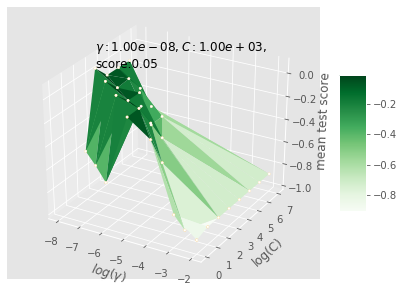

In [160]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize = (7,5))
ax = fig.gca(projection='3d')
xx = result_df.param_regressor__svr__gamma.astype(float)
yy = result_df.param_regressor__svr__C.astype(float)
zz = result_df.mean_test_score.astype(float)
max_index = np.argmax(zz)

surf = ax.plot_trisurf(np.log10(xx), np.log10(yy), zz, cmap=cm.Greens, linewidth=0.1)
ax.scatter3D(np.log10(xx), np.log10(yy), zz, c = 'orange', s = 5)
# mark the best score
ax.scatter3D(np.log10(xx), np.log10(yy), zz, c = 'w', s = 5, alpha = 1)
text = '$\gamma :{:.2e}, C:{:.2e}$,\nscore:{:.2f}'.format(xx[max_index], yy[max_index], zz[max_index])
ax.text(np.log10(xx[max_index]), np.log10(yy[max_index]), 
        zz[max_index],text,
        fontsize=12)

ax.set_xlabel('$log(\gamma)$')
ax.set_ylabel('log(C)')
ax.set_zlabel('mean test score')
fig.colorbar(surf, shrink=0.5, aspect=5)
fig.savefig('toc_nmr+svr_toc_grid_scores_3D.png')

### Manualy transform y

In [164]:
%%time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
scaler = StandardScaler()
y_train_s = scaler.fit_transform(y_train.reshape(-1,1))
y_test_s = scaler.transform(y_test.reshape(-1,1))
ridge = make_pipeline(StandardScaler(), PCA(whiten = True), Ridge())
ridge.fit(X_train, y_train_s)

print('Training set score: {:.2f}'.format(ridge.score(X_train, y_train_s)))
print('Test set score: {:.2f}'.format(ridge.score(X_test, y_test_s)))

Training set score: 1.00
Test set score: 0.37
CPU times: user 21.2 ms, sys: 3.84 ms, total: 25 ms
Wall time: 17.8 ms


## TC

In [125]:
y = merge_df.tc_percent.values

## GridsearchCV

In [23]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

ridge = make_pipeline(StandardScaler(), PCA(whiten = True), Ridge())
params = {'ridge__alpha': np.logspace(-3, 3, 7)}
grid = GridSearchCV(ridge, param_grid = params, cv = 5, n_jobs = -1)

grid.fit(X, y)

print('The best cv score: {:.2f}'.format(grid.best_score_))
print('The best parameter: {}'.format(grid.best_params_))
print(grid.best_estimator_)

The best cv score: 0.87
The best parameter: {'ridge__alpha': 0.001}
Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=True)),
                ('ridge',
                 Ridge(alpha=0.001, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)
CPU times: user 139 ms, sys: 15 ms, total: 154 ms
Wall time: 324 ms


In [24]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(StandardScaler(), PCA(n_components = 5, whiten = True), SVR())
params = {
    'svr__C': np.logspace(-3, 3, 7),
    'svr__gamma': np.logspace(-3, 3, 7)
}
grid = GridSearchCV(pipe, param_grid = params, cv = 5, n_jobs = -1)

grid.fit(X, y)

print('The best cv score: {:.2f}'.format(grid.best_score_))
print('The best parameter: {}'.format(grid.best_params_))
print(grid.best_estimator_)

The best cv score: 0.88
The best parameter: {'svr__C': 100.0, 'svr__gamma': 0.01}
Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=True)),
                ('svr',
                 SVR(C=100.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                     gamma=0.01, kernel='rbf', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)
CPU times: user 642 ms, sys: 44.9 ms, total: 687 ms
Wall time: 1.9 s


In [126]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import NMF
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(NMF(n_components = 5, random_state = 24), SVR())
params = {
    'svr__C': np.logspace(0, 7, 8),
    'svr__gamma': np.logspace(-8, 1, 10)
}
grid = GridSearchCV(pipe, param_grid = params, cv = 5, n_jobs = -1)

grid.fit(X, y)

print('The best cv score: {:.2f}'.format(grid.best_score_))
print('The best parameter: {}'.format(grid.best_params_))
print(grid.best_estimator_)

The best cv score: 0.91
The best parameter: {'svr__C': 10000.0, 'svr__gamma': 1e-06}
Pipeline(memory=None,
         steps=[('nmf',
                 NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0,
                     max_iter=200, n_components=5, random_state=24,
                     shuffle=False, solver='cd', tol=0.0001, verbose=0)),
                ('svr',
                 SVR(C=10000.0, cache_size=200, coef0=0.0, degree=3,
                     epsilon=0.1, gamma=1e-06, kernel='rbf', max_iter=-1,
                     shrinking=True, tol=0.001, verbose=False))],
         verbose=False)
CPU times: user 1.44 s, sys: 91.7 ms, total: 1.53 s
Wall time: 25.7 s


In [131]:
result_df = pd.DataFrame(grid.cv_results_)
result_df = result_df[result_df.mean_test_score > -1].reset_index(drop = True)

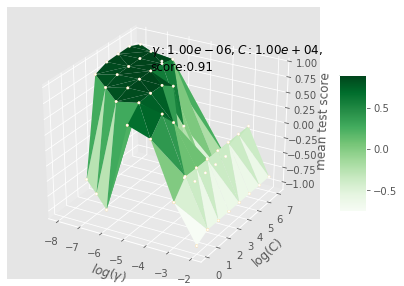

In [132]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize = (7,5))
ax = fig.gca(projection='3d')
xx = result_df.param_svr__gamma.astype(float)
yy = result_df.param_svr__C.astype(float)
zz = result_df.mean_test_score.astype(float)
max_index = np.argmax(zz)

surf = ax.plot_trisurf(np.log10(xx), np.log10(yy), zz, cmap=cm.Greens, linewidth=0.1)
ax.scatter3D(np.log10(xx), np.log10(yy), zz, c = 'orange', s = 5)
# mark the best score
ax.scatter3D(np.log10(xx), np.log10(yy), zz, c = 'w', s = 5, alpha = 1)
text = '$\gamma :{:.2e}, C:{:.2e}$,\nscore:{:.2f}'.format(xx[max_index], yy[max_index], zz[max_index])
ax.text(np.log10(xx[max_index]), np.log10(yy[max_index]), 
        zz[max_index],text,
        fontsize=12)

ax.set_xlabel('$log(\gamma)$')
ax.set_ylabel('log(C)')
ax.set_zlabel('mean test score')
fig.colorbar(surf, shrink=0.5, aspect=5)
fig.savefig('tc_nmr+svr_toc_grid_scores_3D.png')

# Visualize the prediction accuracy
$CaCO_{3}$ and TC<br>
The best model of NMF+SVR.

In [3]:
y_ca = merge_df.caco3_percent.values
y_tc = merge_df.tc_percent.values
#y_toc = merge_df.toc_percent.values

In [5]:
from sklearn.decomposition import NMF
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline

ca_svr = make_pipeline(NMF(n_components = 5, random_state = 24), SVR(C = 1000000, gamma = 1e-07))
ca_svr.fit(X,y_ca)
tc_svr = make_pipeline(NMF(n_components = 5, random_state = 24), SVR(C = 10000, gamma = 1e-06))
tc_svr.fit(X,y_tc)

# The score of cross-validation is more robust than this score. 
# This one is just to see how the fitting goes.
print('The score of the CaCO3: {:.2f}'.format(ca_svr.score(X, y_ca)))
print('The score of the TC: {:.2f}'.format(tc_svr.score(X, y_tc)))

The score of the CaCO3: 0.95
The score of the TC: 0.96


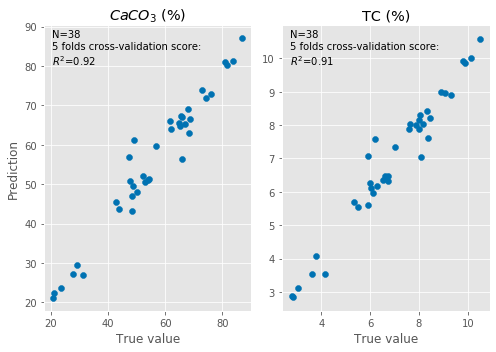

In [21]:
y_p = [ca_svr.predict(X), tc_svr.predict(X)]
scores = [0.92, 0.91] # this is from the cross-validation results above

fig, axes = plt.subplots(1, 2, figsize = (7, 5))

for ax, y, prediction, title, score in zip(axes, [y_ca, y_tc], y_p, [r'$CaCO_{3}$ (%)', 'TC (%)'], scores):
    ax.scatter(y, prediction)
    ax.set_xlabel('True value')
    ax.set_title(title)
    ax.text(0.04, 0.92, 'N=38\n5 folds cross-validation score:\n{}={}'.format(r'$R^{2}$', score), 
            horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
axes[0].set_ylabel('Prediction')
fig.tight_layout()
fig.savefig('truevalue_prediction.png')

# Summary
After larger scale of grid search on the CaCO3 data, the combination of NMF+SVR actually can provide better performance, 0.92. Therefore, I use the combination of NMF+SVR for gridsearch on TOC and TC. TC provide similarily good performance, 0.91, while TOC is so bad. I can produce the TC and CaCO3 profiles of these two cores in the resolution of XRF when JC wishs.

TOC-problem<br>
Even with the help of transforming y (TOC) by StandardScaler(), the performance is only improved from negative to 0.05. But, I'm not sure if the way of using TransformedTargetRegressor() is right. I'll mannualy do the grid search if JC is interested in that.

# Produce TC and $CaCO_{3}$ profiles

# Read and build spectral dataset of core SO264-14-1
For the core SO264-15-2, I just need to read the dataset I prepared already.

In [201]:
spe_dir = glob.glob('SO264-14-1/Run 1 at  10kV/*.spe')
spe_all = []
depth_all = []
cps_all = []
file_name = []

for spe in spe_dir:
    start_depth = int(spe.split()[3].split('_')[-1])
    file_name.append(spe.split('/')[-1])
    with open(spe, 'r') as f:
        content = []
        lines = f.readlines()
        for line in lines[49:]:
            content = np.hstack((content, line.split()))

        spe_all.append(content.astype(int))
        # the depth read from the xrf depth is in mm, but the composite depth is in cm
        # also I check the depth is always starts from 0.0 and in 10.0 mm resulotion
        # so I use this trick to make it to cm  e.g. '1000.0\n'
        depth_all.append(int(lines[13][:-4]) + start_depth)
        cps_all.append(int(lines[28]))

In [203]:
data_df = pd.DataFrame(spe_all)
data_df['composite_depth_cm'] = depth_all
data_df['cps'] = cps_all
data_df['file_name'] = file_name

In [204]:
data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2041,2042,2043,2044,2045,2046,2047,composite_depth_cm,cps,file_name
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1708,218346,SO264-14-1_1641 670.0mm 10s 10kV 150uA No-F...
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1703,213920,SO264-14-1_1641 620.0mm 10s 10kV 150uA No-F...
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1072,161034,SO264-14-1_1041 310.0mm 10s 10kV 150uA No-F...
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1075,196662,SO264-14-1_1041 340.0mm 10s 10kV 150uA No-F...
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,792,172075,SO264-14-1_0741 510.0mm 10s 10kV 150uA No-F...


In [205]:
data_df.shape

(1828, 2051)

## Check duplicates

In [206]:
data_df.loc[data_df.composite_depth_cm.duplicated(keep = False), ['file_name', 'composite_depth_cm']]#.to_csv('duplicates.csv')

,file_name,composite_depth_cm
1051,SO264-14-1_0000 420.0mm 10s 10kV 150uA No-F...,42
1530,SO264-14-1_0041 10.0mm 10s 10kV 150uA No-F...,42


Only one pair of duplicate so I simply keep the first one.

In [207]:
clean_df = data_df[~data_df.composite_depth_cm.duplicated()]
clean_df.shape

(1827, 2051)

## Expot data

In [208]:
clean_df.to_csv('clean_spe_SO264-14-1.csv', index = False)

## Combile two cores' data

In [219]:
core_152_df = pd.read_csv('clean_spe_SO264-15-2.csv')
core_141_df = pd.read_csv('clean_spe_SO264-14-1.csv')
clean_df = pd.concat([core_152_df, core_141_df], axis = 0)
print(core_152_df.shape)
print(core_141_df.shape)
print(clean_df.shape)

(1340, 2051)
(1827, 2051)
(3167, 2051)


## Predict them!

In [220]:
mask_c = (clean_df.columns != 'file_name') & (clean_df.columns != 'composite_depth_cm')
X = clean_df.loc[:, mask_c].values

prediction_df = clean_df.loc[:, ~mask_c].copy()
prediction_df['caco3_percent'] = ca_svr.predict(X)
prediction_df['tc_percent'] = tc_svr.predict(X)

In [221]:
prediction_df.head()

,composite_depth_cm,file_name,caco3_percent,tc_percent
0,1082,SO264-15-2_1048 340.0mm 10s 10kV 150uA No-F...,73.851006,8.960110
1,1079,SO264-15-2_1048 310.0mm 10s 10kV 150uA No-F...,77.408529,9.328562
2,1404,SO264-15-2_1348 560.0mm 10s 10kV 150uA No-F...,46.358370,5.824017
3,350,SO264-15-2_0348 20.0mm 10s 10kV 150uA No-F...,53.129747,6.639450
4,41,SO264-15-2_0000 410.0mm 10s 10kV 150uA No-F...,46.268140,5.822396


### Export prediction

In [224]:
prediction_df.to_csv('prediction_tc+ca.csv', index = False)